In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import pickle
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import initializers

In [2]:
np.random.seed(123)

# Setting parameters
sample_dim = 1000
test_sample_dim = 100
input_dim = 200
weight_dim = 900
learning_rate = 0.01
batch = 32
epoch = 300
t_n = 1.0 / np.sqrt(weight_dim)
L = 3

In [3]:
# Define the nonlinear activation function
c = np.sqrt(0.21747 / (2 * np.sqrt(2 * np.pi)))


def activ_function(x):
    return (keras.backend.sigmoid(x) - 0.5) / c


b = 2 * (0.258961) / np.sqrt(2 * np.pi) / 0.208276
a = 2 * 0.0561939 / (np.sqrt(2 * np.pi) * (c ** 2))


def dactiv_function(x):
    return np.exp(-x) / (((1 + np.exp(-x)) ** 2) * c)

In [4]:
# Generate the training data
coeffi = np.random.normal(size=(1, input_dim))
coeffi = np.sqrt(input_dim) * coeffi / np.linalg.norm(coeffi)


def f_aim(x):
    x_sum = activ_function(np.inner(coeffi, x))
    return x_sum


train_data = np.random.normal(size=(sample_dim, input_dim))
train_data = train_data - train_data.mean(axis=0)
train_data = train_data / train_data.std(axis=0) / np.sqrt(input_dim)
train_labels = np.array(list(map(f_aim, train_data)))
# Generate the test data and test loss
test_data = np.random.normal(size=(test_sample_dim, input_dim))
test_data = test_data - test_data.mean(axis=0)
test_data = test_data / test_data.std(axis=0) / np.sqrt(input_dim)
test_labels = np.array(list(map(f_aim, test_data)))

In [5]:
# Create the model
inputs = tf.keras.Input(shape=(input_dim,))
x_10 = tf.keras.layers.Dense(weight_dim, activation=activ_function,
                             use_bias=False, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0))(inputs)
x_1 = keras.layers.Lambda(lambda x: x * t_n)(x_10)
layer_1 = keras.models.Model(inputs, x_1, name="first_layer")
x_20 = tf.keras.layers.Dense(weight_dim, activation=activ_function,
                             use_bias=False, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0))(x_1)
x_2 = keras.layers.Lambda(lambda x: x * t_n)(x_20)
layer_2 = keras.models.Model(inputs, x_2, name="second_layer")
x_30 = tf.keras.layers.Dense(weight_dim, activation=activ_function,
                             use_bias=False, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0))(x_2)
x_3 = keras.layers.Lambda(lambda x: x * t_n)(x_30)
layer_3 = keras.models.Model(inputs, x_3, name="third_layer")
outputs = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.0))(
    x_3)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary(line_length=None, positions=None, print_fn=None)
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 900)               180000    
_________________________________________________________________
lambda (Lambda)              (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 900)               810000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 900)               810000    
_________________________________________________________________
lambda_2 (Lambda)            (None, 900)               0     

In [6]:
# Records the weights throughout the training process
X_0 = train_data
Y_0 = train_labels
X_1 = []
X_2 = []
X_3 = []

X_1.append(layer_1.predict(train_data))
X_2.append(layer_2.predict(train_data))
X_3.append(layer_3.predict(train_data))

Ws = []


class MyCallback(keras.callbacks.Callback):
    def __init__(self):
        self.Y_pred = []

    def on_epoch_end(self, epoch, logs={}):
        X_1.append(layer_1.predict(train_data))
        X_2.append(layer_2.predict(train_data))
        X_3.append(layer_3.predict(train_data))
        self.Y_pred.append(model.predict(test_data))
        Ws.append(model.get_weights())


callback = MyCallback()

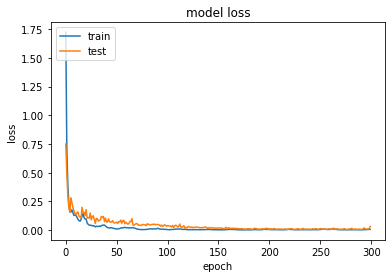

Test score: 0.03131871297955513


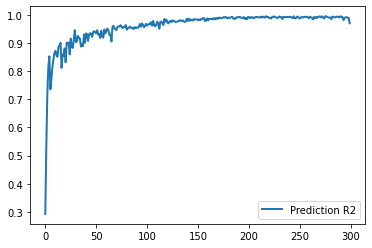

In [7]:
history = model.fit(train_data, train_labels, epochs=epoch, batch_size=batch, verbose=False,
                    validation_data=(test_data, test_labels), callbacks=[callback])
# Record the training and test error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Trainig and testing loss_L=%d_n=%d_d=%d' % (L, sample_dim, weight_dim))
plt.show()
score = model.evaluate(test_data, test_labels, verbose=0)
print('Test score:', score[0])

R2_predict = []
for i in range(0, epoch):
    R2_predict.append(r2_score(test_labels, callback.Y_pred[i]))
f, ax = plt.subplots(1, 1)
ax.plot(R2_predict, label='Prediction R2', linewidth=2)
ax.legend()
f.savefig('R2 prediction')

In [9]:
ylim = [0, 70]
bins = 50


def cross(X):
    return np.dot(X, np.transpose(X))


# Histogram eigenvalues of each X'X
def histeig(eigs, ax, xgrid=None, dgrid=None, bins=100, xlim=None, ylim=None, title=None):
    if xlim is not None:
        eigs = eigs[np.nonzero(eigs <= xlim[1])[0]]
        h = ax.hist(eigs, bins=np.linspace(xlim[0], xlim[1], num=bins))
    else:
        h = ax.hist(eigs, bins=bins)
    if xgrid is not None:
        space = h[1][1] - h[1][0]
        ax.plot(xgrid, dgrid * len(eigs) * space, 'r', label='Prediction at initial', linewidth=2)
        ax.legend()
    ax.set_title(title, fontsize=12)
    ax.set_xlim(xlim)
    if ylim is None:
        ax.set_ylim([0, max(h[0]) * 1.5])
    else:
        ax.set_ylim(ylim)
    return ax

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


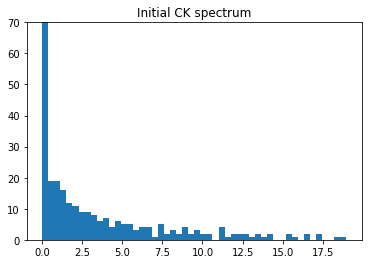

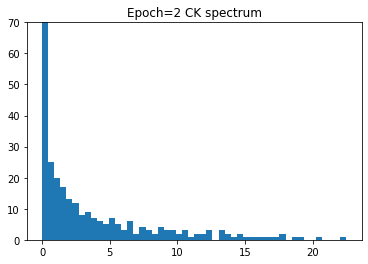

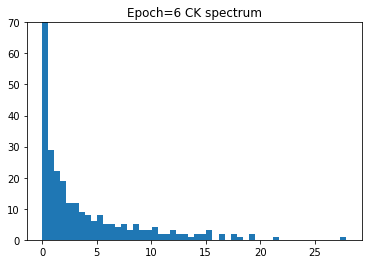

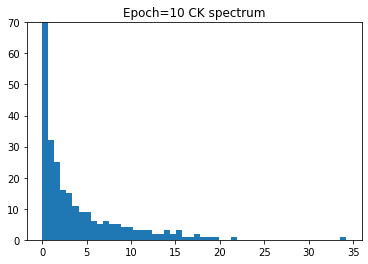

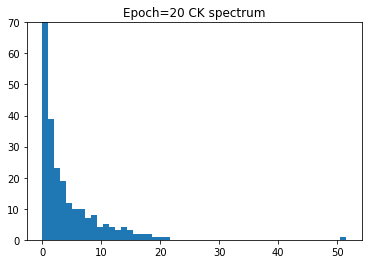

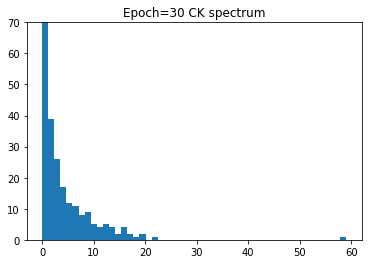

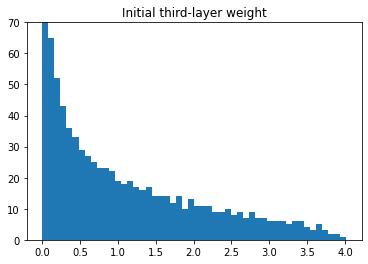

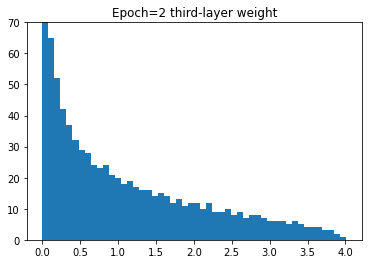

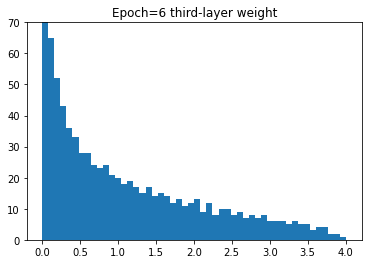

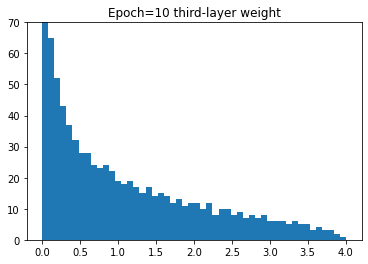

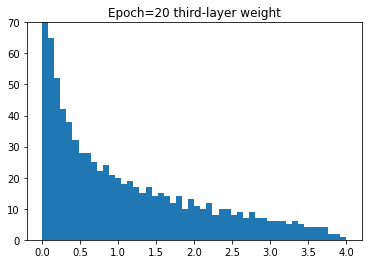

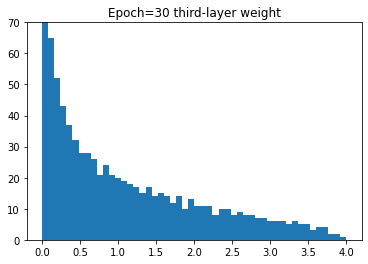

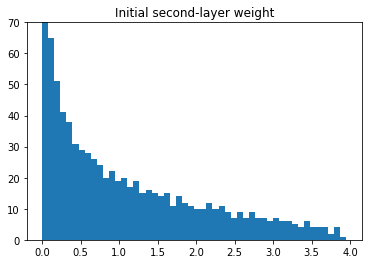

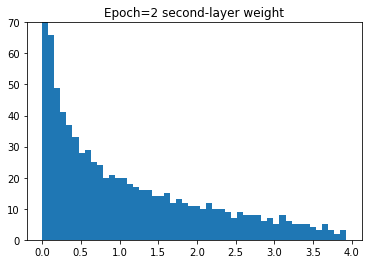

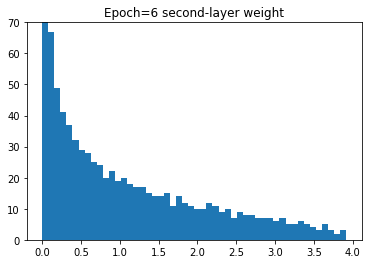

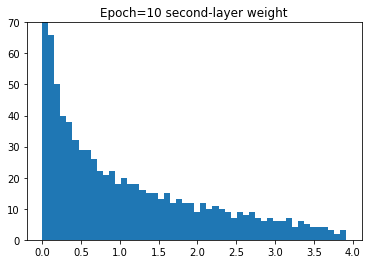

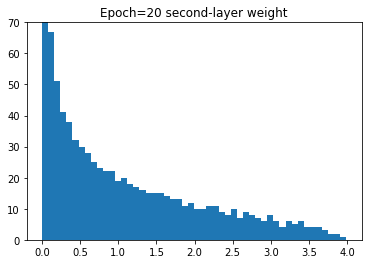

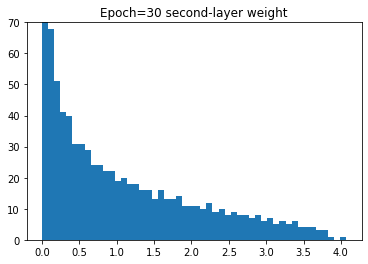

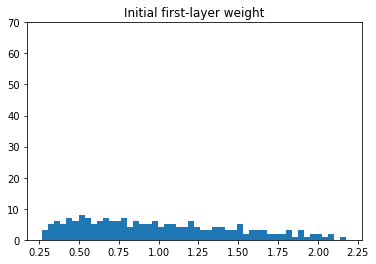

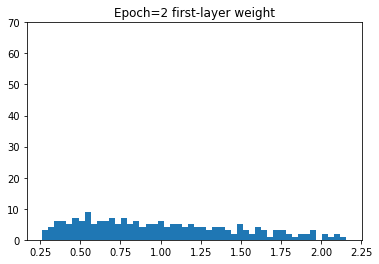

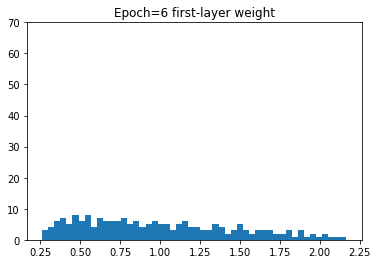

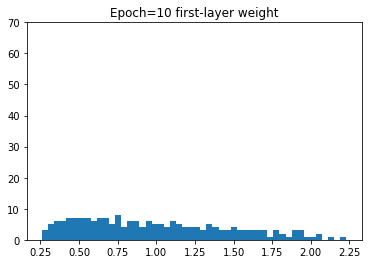

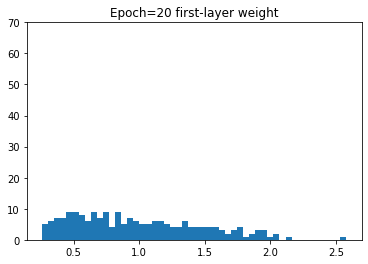

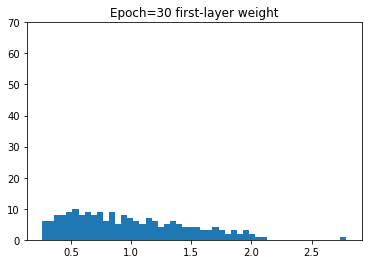

In [10]:
X = [X_0, X_1, X_2, X_3]
epoch_list = [2, 6, 10, 20, 30]
# Plot empirical spectrum of CK matrix at different epochs
eigs_initial = np.linalg.eigvalsh(cross(X[L][0]))
f, ax = plt.subplots(1, 1)
histeig(eigs_initial, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Initial CK spectrum')
plt.savefig('initial_CK.png')
for k in epoch_list:
    eigs = np.linalg.eigvalsh(cross(X[L][k]))
    f, ax = plt.subplots(1, 1)
    histeig(eigs, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Epoch=%d CK spectrum' % k)
    plt.savefig('Epoch=%d_CK.png' % k)

# Plot empirical spectrum of gram of the weight matrix at different epochs 
eigs_initial_w = np.linalg.eigvalsh(cross(t_n*Ws[0][L-1]))
f, ax = plt.subplots(1, 1)
histeig(eigs_initial_w, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Initial third-layer weight')
plt.savefig('initial_third_layer_weight.png')
for k in epoch_list:
    eigs = np.linalg.eigvalsh(cross(t_n*Ws[k][L-1]))
    f, ax = plt.subplots(1, 1)
    histeig(eigs, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Epoch=%d third-layer weight' % k)
    plt.savefig('Epoch=%d_third-layer_weight.png' % k)

eigs_initial_w = np.linalg.eigvalsh(cross(t_n*Ws[0][L-2]))
f, ax = plt.subplots(1, 1)
histeig(eigs_initial_w, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Initial second-layer weight')
plt.savefig('initial_second_layer_weight.png')
for k in epoch_list:
    eigs = np.linalg.eigvalsh(cross(t_n*Ws[k][L-2]))
    f, ax = plt.subplots(1, 1)
    histeig(eigs, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Epoch=%d second-layer weight' % k)
    plt.savefig('Epoch=%d_second-layer_weight.png' % k)
    
eigs_initial_w = np.linalg.eigvalsh(cross(t_n*Ws[0][L-3]))
f, ax = plt.subplots(1, 1)
histeig(eigs_initial_w, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim,title='Initial first-layer weight')
plt.savefig('initial_first_layer_weight.png')
for k in epoch_list:
    eigs = np.linalg.eigvalsh(cross(t_n*Ws[k][L-3]))
    f, ax = plt.subplots(1, 1)
    histeig(eigs, ax, xgrid=None, dgrid=None, bins=bins, ylim=ylim, title='Epoch=%d first-layer weight' % k)
    plt.savefig('Epoch=%d_first-layer_weight.png' % k)